# forward model BGS observables (photometry and spectra) for LGalaxies

In [1]:
import os 
import h5py 
import pickle 
import numpy as np 
import scipy as sp
# --- astropy --- 
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import astropy.table as aTable
from speclite import filters as specFilter

In [2]:
!pip install corner

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# --- plotting --- 
import corner as dfm
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
version = '1.3' # 06/25/2021 

In [5]:
dat_dir = '/global/cfs/cdirs/desi/mocks/LGal_spectra'

In [6]:
# read in LGal SED
lgal_dict = pickle.load(open(os.path.join(dat_dir, 'Lgal_fsps_minimocha.p'), 'rb'))

In [7]:
# read BGS photometry for comparison
bgs = aTable.Table.read('/global/cfs/cdirs/desi/science/gqp/provabgs.sv3.sbi.v0.fits')

g_bgs = 22.5 - 2.5 * np.log10(bgs['FLUX_G'])
r_bgs = 22.5 - 2.5 * np.log10(bgs['FLUX_R']) 
z_bgs = 22.5 - 2.5 * np.log10(bgs['FLUX_Z']) 

## compile meta-data

In [8]:
meta = {} 
meta['t_lookback']  = lgal_dict['t_sfh']
meta['dt']          = lgal_dict['dt']
meta['sfh_disk']    = lgal_dict['sfh_disk']
meta['sfh_bulge']   = lgal_dict['sfh_bulge']
meta['Z_disk']      = lgal_dict['Z_disk']
meta['Z_bulge']     = lgal_dict['Z_bulge']
meta['logM_disk']   = [np.log10(np.sum(sfh)) for sfh in lgal_dict['sfh_disk']]
meta['logM_bulge']  = [np.log10(np.sum(sfh)) for sfh in lgal_dict['sfh_bulge']]
meta['logM_total']  = [np.log10(np.sum(sfh0) + np.sum(sfh1)) for sfh0, sfh1 in zip(lgal_dict['sfh_disk'], lgal_dict['sfh_bulge'])]

# mass weighted age and metallicity 
t_age_mw, z_mw = [], [] 
for i in range(len(lgal_dict['dt'])): 
    t_age_mw.append(
            np.sum(lgal_dict['t_sfh'][i] * (lgal_dict['sfh_disk'][i] + lgal_dict['sfh_bulge'][i])) /
            np.sum(lgal_dict['sfh_disk'][i] + lgal_dict['sfh_bulge'][i])
            )
    z_mw.append(
            np.sum(lgal_dict['Z_disk'][i] * lgal_dict['sfh_disk'][i] +
                lgal_dict['Z_bulge'][i] * lgal_dict['sfh_bulge'][i]) / 
            np.sum(lgal_dict['sfh_disk'][i] + lgal_dict['sfh_bulge'][i])
            )
meta['t_age_MW']    = t_age_mw 
meta['Z_MW']        = z_mw
meta['redshift']    = lgal_dict['redshift'] 
meta['cosi']        = lgal_dict['cosi']
meta['tau_ism']     = lgal_dict['tauISM']
meta['tau_bc']      = lgal_dict['tauBC']
meta['vd_disk']     = lgal_dict['vd_disk']
meta['vd_bulge']    = lgal_dict['vd_bulge']
print('%.2f < z < %.2f' % (np.min(meta['redshift']), np.max(meta['redshift'])))

0.05 < z < 0.40


<ipython-input-8-0c9cf240f08a>:9: RuntimeWarning: divide by zero encountered in log10
  meta['logM_bulge']  = [np.log10(np.sum(sfh)) for sfh in lgal_dict['sfh_bulge']]


## generate noiseless photometry

In [9]:
# load DECAM g, r, z and WISE W1-4
filters_desi = specFilter.load_filters('decam2014-g', 'decam2014-r', 'decam2014-z', 'wise2010-W1', 'wise2010-W2')

def get_photometry(w, f): 
    ''' calculate photometry in nanomaggies
    '''
    return 1e9* np.array(list((filters_desi.get_ab_maggies(np.atleast_2d(f), w)).as_array()[0]))

In [10]:
photo_true = np.array([get_photometry(w, f) for w, f, in zip(lgal_dict['wave_obs'], lgal_dict['flux_dust'])])
mag_true = 22.5 - 2.5 * np.log10(photo_true)

(0.0, 1.5)

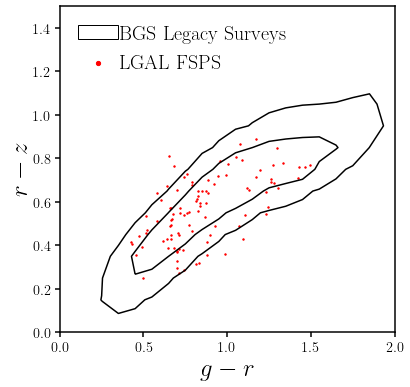

In [11]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
dfm.hist2d(g_bgs - r_bgs, r_bgs - z_bgs, color='k', levels=[0.68, 0.95], 
           range=[[-1., 3.], [-1., 3.]], bins=40, smooth=0.5,             
           plot_datapoints=False, fill_contours=False, plot_density=False, linewidth=0.5, ax=sub)
sub.fill_between([0],[0],[0], fc='none', ec='k', label='BGS Legacy Surveys') 
sub.scatter(mag_true[:,0] - mag_true[:,1], mag_true[:,1] - mag_true[:,2], c='r', s=2, label='LGAL FSPS')
sub.legend(loc='upper left', handletextpad=0.1, markerscale=3, fontsize=20)
sub.set_xlabel('$g-r$', fontsize=25)
sub.set_xlim(0., 2.)
sub.set_ylabel('$r-z$', fontsize=25)
sub.set_ylim(0., 1.5)

## assign uncertainties and apply noise model
assign $g, r, z$ uncertainties based on nearest neighbor match to BGS data in ($r$, $g-r$, $r-z$) space

In [12]:
bgs_photo       = np.zeros((len(bgs), 5)) 
bgs_photo_ivar  = np.zeros((len(bgs), 5))
bgs_fiberflux   = np.zeros(len(bgs)) # r-band fiber flux
for ib, band in enumerate(['G', 'R', 'Z', 'W1', 'W2']): 
    bgs_photo[:,ib]         = bgs['FLUX_%s' % band]
    bgs_photo_ivar[:,ib]    = bgs['FLUX_IVAR_%s' % band] 
bgs_rfiberflux = bgs['FIBERFLUX_R']

In [13]:
from scipy.spatial import cKDTree as KDTree
# construct KD tree from BGS targets (currently downsampled) 
bgs_features = np.array([r_bgs, g_bgs - r_bgs, r_bgs - z_bgs]).T
tree = KDTree(bgs_features) 
# match ivars and fiberflux 
lgal_features = np.array([mag_true[:,1], mag_true[:,0] - mag_true[:,1], mag_true[:,1] - mag_true[:,2]]).T
dist, indx = tree.query(lgal_features)

photo_ivars = bgs_photo_ivar[indx,:] 
photo_rfiber_true = bgs_rfiberflux[indx] 

(0.0, 1.5)

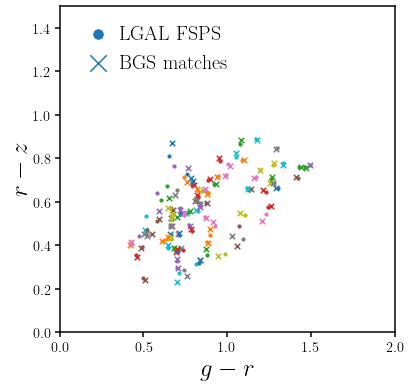

In [14]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
for i in range(len(indx)):
    sub.scatter(mag_true[i,0] - mag_true[i,1], mag_true[i,1] - mag_true[i,2], c='C%i' % i, s=10, label='LGAL FSPS')
    sub.scatter(g_bgs[indx[i]] - r_bgs[indx[i]], r_bgs[indx[i]] - z_bgs[indx[i]], c='C%i' % i, marker='x', s=30, label='BGS matches')
    if i == 0: sub.legend(loc='upper left', handletextpad=0.1, markerscale=3, fontsize=20)
sub.set_xlabel('$g-r$', fontsize=25)
sub.set_xlim(0., 2.)
sub.set_ylabel('$r-z$', fontsize=25)
sub.set_ylim(0., 1.5)

In [15]:
# apply noise model to photometry
photo_meas = photo_true + photo_ivars**-0.5 * np.random.randn(photo_true.shape[0], photo_true.shape[1]) 

In [16]:
# assign fiber fraction --- fraction of light that enters the fiber aperture
f_fiber = photo_rfiber_true/photo_true[:,1] # (r fiber flux) / (r total flux) 
assert f_fiber.max() <= 1.

meta['logM_fiber'] = np.log10(f_fiber) + meta['logM_total']

# apply uncertainty to fiber flux as well 
photo_rivar_fiber = f_fiber**-2 * photo_ivars[:,1]     
photo_rfiber_meas = photo_rfiber_true + photo_rivar_fiber**-0.5 * np.random.randn(photo_true.shape[0]) 

## scale SED spectra by fiber fraction

In [22]:
# interpolate to linear-spaced wavelength bin
wave_lin = np.arange(1e3, 3e5, 0.2)
flux_dust_interp = np.zeros((len(lgal_dict['flux_dust']), len(wave_lin)))
for i, _wave, _flux in zip(np.arange(len(lgal_dict['flux_dust'])), lgal_dict['wave_obs'], lgal_dict['flux_dust']): 
    interp_flux_dust = sp.interpolate.interp1d(_wave.to(u.AA).value, _flux.to(1e-17 * u.erg/u.s/u.AA/u.cm**2).value, fill_value='extrapolate') 
    flux_dust_interp[i,:] = interp_flux_dust(wave_lin) 

In [23]:
# scaling down noiseless Lgal SED spectra by fiber fraction 
spectra_fiber = flux_dust_interp * f_fiber[:,None] # 10e-17 erg/s/cm2/A

(1000.0, 10000.0)

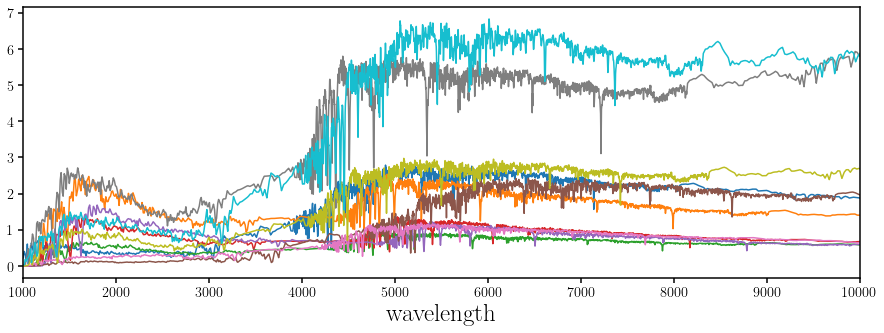

In [29]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for f in spectra_fiber[::10]: 
    sub.plot(wave_lin, f)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(1e3, 1e4)

# Apply BGS noise model

In [30]:
!pip install git+https://github.com/desi-bgs/feasiBGS.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/desi-bgs/feasiBGS.git to /tmp/pip-req-build-d18650ir
  Running command git clone -q https://github.com/desi-bgs/feasiBGS.git /tmp/pip-req-build-d18650ir
  Created wheel for feasibgs: filename=feasibgs-0.1-py3-none-any.whl size=47422 sha256=ebfafbbfe58de54d033e4ffd12dfcfebb92762e5f9aff6635a1920ca8c34c4f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-yggfntr3/wheels/f7/d7/9d/824c3b88b5bd8c28b8c576f20984e3cf31a80def7e3deae10a
Successfully built feasibgs


In [31]:
from feasibgs import spectral_sims as BGS_spec_sim
from feasibgs import forwardmodel as BGS_fm

# read in nominal dark sky
Idark = BGS_spec_sim.nominal_dark_sky()

# BGS forward model object
fdesi = BGS_fm.fakeDESIspec()

spectra_bgs = {} 

fbgs = os.path.join('/global/cscratch1/sd/chahah/gqp_mc/', 'mini_mocha', 'lgal_fsps.bgs_spec.v%s.fits' % version)
print(fbgs)
bgs_spec = fdesi.simExposure(
        wave_lin,        # wavelength  
        spectra_fiber,            # fiber spectra flux 
        exptime=180.,
        airmass=1.1,
        Isky=[Idark[0].value, Idark[1].value],
        filename=fbgs
    )

spectra_bgs['wave_b'] = bgs_spec.wave['b']
spectra_bgs['wave_r'] = bgs_spec.wave['r']
spectra_bgs['wave_z'] = bgs_spec.wave['z']
spectra_bgs['flux_b'] = bgs_spec.flux['b']
spectra_bgs['flux_r'] = bgs_spec.flux['r']
spectra_bgs['flux_z'] = bgs_spec.flux['z']

spectra_bgs['ivar_b'] = bgs_spec.ivar['b']
spectra_bgs['ivar_r'] = bgs_spec.ivar['r']
spectra_bgs['ivar_z'] = bgs_spec.ivar['z']

spectra_bgs['res_b'] = bgs_spec.resolution_data['b']
spectra_bgs['res_r'] = bgs_spec.resolution_data['r']
spectra_bgs['res_z'] = bgs_spec.resolution_data['z']

/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/lgal_fsps.bgs_spec.v1.3.fits
INFO:spectra.py:159:write_spectra: iotime 0.639 sec to write lgal_fsps.bgs_spec.v1.3.fits at 2021-06-25T06:13:05.697407


In [32]:
################################################################################
# write out everything 
# meta-data to pickle file
fmeta = os.path.join('/global/cscratch1/sd/chahah/gqp_mc/', 'mini_mocha', 'lgal_fsps.mini_mocha.v%s.meta.p' % (version))
pickle.dump(meta, open(fmeta, 'wb')) # meta-data
    
# the rest 
fout = h5py.File(os.path.join('/global/cscratch1/sd/chahah/gqp_mc/', 'mini_mocha', 'lgal_fsps.mini_mocha.v%s.hdf5' % (version)), 'w')
# photometry  
for i, b in enumerate(['g', 'r', 'z', 'w1', 'w2']): 
    # 'true' 
    fout.create_dataset('photo_flux_%s_true' % b, data=photo_true[:,i]) 
    fout.create_dataset('photo_ivar_%s_true' % b, data=photo_ivars[:,i]) 
    # 'measured'
    fout.create_dataset('photo_flux_%s_meas' % b, data=photo_meas[:,i]) 

# fiber flux 
fout.create_dataset('photo_fiberflux_r_true', data=photo_rfiber_true) 
fout.create_dataset('photo_fiberflux_r_meas', data=photo_rfiber_meas) 
fout.create_dataset('photo_fiberflux_r_ivar', data=photo_rivar_fiber) 
fout.create_dataset('frac_fiber', data=f_fiber) # fraction of flux in fiber

# spectroscopy 
# noiseless source spectra 
wlim = (wave_lin < 2e5) & (wave_lin > 1e3) # truncating the spectra  
fout.create_dataset('spec_wave_source', data=wave_lin[wlim]) 
fout.create_dataset('spec_flux_source', data=flux_dust_interp[:,wlim]) 
# noiseless source spectra in fiber 
fout.create_dataset('spec_fiber_flux_source', data=spectra_fiber[:,wlim])

# BGS source spectra 
for k in spectra_bgs.keys(): 
    fout.create_dataset('spec_%s_bgs' % k, data=spectra_bgs[k]) 
fout.close() 